Imports and installs

In [ ]:
!pip uninstall -y tensorflow
!pip uninstall -y keras
!pip install -q tensorflow==2.15.0
!pip install -q keras==2.10.0
!pip install -q numpy pillow
!pip install -U -q segmentation-models
!pip install -U -q segmentation-models-pytorch

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.10.0 which is incompatible.


In [ ]:
import imgaug as ia
from imgaug import augmenters as iaa
import pandas as pd
import numpy as np
import cv2

# Data aug: 24-> 480 images

In [ ]:
import os
import cv2
import numpy as np
import imgaug.augmenters as iaa

# Function to load an image and its corresponding mask
def load_image_and_mask(image_path, mask_path):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return image, mask

# Function to save augmented images and masks
def save_augmented_images_and_masks(augmented_images, augmented_masks, image_save_dir, mask_save_dir, base_filename, start_index):
    for i, (aug_img, aug_mask) in enumerate(zip(augmented_images, augmented_masks)):
        aug_img_path = os.path.join(image_save_dir, f"{base_filename}_aug_{start_index + i}.jpg")
        aug_mask_path = os.path.join(mask_save_dir, f"{base_filename}_aug_{start_index + i}.png")
        cv2.imwrite(aug_img_path, aug_img)
        cv2.imwrite(aug_mask_path, aug_mask)

# Define augmentation sequence
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontal flips
    iaa.Affine(rotate=(-25, 25)),  # random rotations
    iaa.Crop(percent=(0, 0.3)),  # random crops
    iaa.Multiply((0.5, 1.5)),  # change brightness
    iaa.GaussianBlur(sigma=(0, 0.5))  # blur images
])

# Number of augmentations per image
num_augmentations = 20

# Paths
image_dir = '/content/train_images'
mask_dir = '/content/masks'
aug_image_save_dir = 'augmented_train'
aug_mask_save_dir = 'augmented_masks'
os.makedirs(aug_image_save_dir, exist_ok=True)
os.makedirs(aug_mask_save_dir, exist_ok=True)

# Perform augmentation
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):
        image_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename.replace('.jpg', '_mask.png'))

        if os.path.exists(mask_path):
            image, mask = load_image_and_mask(image_path, mask_path)

            images = [image] * num_augmentations
            masks = [mask] * num_augmentations

            # Augment images and masks
            augmented_images = seq(images=images)
            augmented_masks = seq(images=masks)

            # Save augmented images and masks
            base_filename = os.path.splitext(filename)[0]
            save_augmented_images_and_masks(augmented_images, augmented_masks, aug_image_save_dir, aug_mask_save_dir, base_filename, start_index=0)


# Resize Images to (256,256,3) format

In [ ]:
# @title
from PIL import Image
import numpy as np

def resize_image_and_mask(image_path, mask_path, size=(256, 256)):
    # Open the image and the mask
    image = Image.open(image_path)
    mask = Image.open(mask_path)

    # Resize the image and the mask
    resized_image = image.resize(size)
    resized_mask = mask.resize(size)

    # Ensure the image has 3 channels
    resized_image = resized_image.convert("RGB")

    # Convert the mask to a numpy array and ensure it has a single channel
    resized_mask = np.array(resized_mask)
    if resized_mask.ndim == 2:  # if the mask is already single-channel
        resized_mask = np.expand_dims(resized_mask, axis=-1)
    elif resized_mask.shape[2] == 3:  # if the mask is RGB
        resized_mask = resized_mask[:, :, 0:1]  # Use the first channel

    # Convert the mask back to an Image
    resized_mask = Image.fromarray(np.uint8(resized_mask))

    return resized_image, resized_mask

# Example usage
image_dir = '/content/augmented_train'
mask_dir = '/content/augmented_masks'

for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):
        image_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename.replace('.jpg', '_mask.png'))

        if os.path.exists(mask_path):
            image, mask = load_image_and_mask(image_path, mask_path)

            images = [image] * num_augmentations
            masks = [mask] * num_augmentations

            # Augment images and masks
            resized_images = seq(images=images)
            augmented_masks = seq(images=masks)

            # Save augmented images and masks
            base_filename = os.path.splitext(filename)[0]
            save_augmented_images_and_masks(augmented_images, augmented_masks, aug_image_save_dir, aug_mask_save_dir, base_filename, start_index=0)

        else:
            print(f"Mask not found for image: {filename}")





resized_image, resized_mask = resize_image_and_mask(image_path, mask_path)



# Load DeepLabv3 model

In [ ]:
# import segmentation_models
# from segmentation_models import segmentation_models_pytorch
from segmentation_models_pytorch import DeepLabV3Plus
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from segmentation_models import get_preprocessing

BACKBONE = 'resnet34'  # You can choose other backbones like 'vgg16', 'inceptionv3', etc.
preprocess_input = get_preprocessing(BACKBONE)

# Load model
model = DeepLabV3Plus(BACKBONE, encoder_weights='imagenet', classes=1, activation='sigmoid')

# Compile model
model.compile(optimizer='adam', loss=bce_jaccard_loss, metrics=[iou_score])


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 119MB/s]


TypeError: compile() got an unexpected keyword argument 'optimizer'

# Test with data generators code

In [ ]:
import albumentations as A
import cv2

# Define an augmentation pipeline
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=35, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5)
])

# Example function to apply augmentations
def augment(image, mask):
    augmented = augmentation_pipeline(image=image, mask=mask)
    return augmented['image'], augmented['mask']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define a generator function
def data_generator(images, masks, batch_size, augment=False):
    while True:
        for start in range(0, len(images), batch_size):
            end = min(start + batch_size, len(images))
            batch_images = []
            batch_masks = []
            for i in range(start, end):
                image = images[i]
                mask = masks[i]
                if augment:
                    image, mask = augment(image, mask)
                image = preprocess_input(image)
                batch_images.append(image)
                batch_masks.append(mask)
            yield np.array(batch_images), np.array(batch_masks)

# Assuming train_images and train_masks are your datasets
train_images, val_images, train_masks, val_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

train_gen = data_generator(train_images, train_masks, batch_size=4, augment=True)
val_gen = data_generator(val_images, val_masks, batch_size=4, augment=False)


# Train model

In [ ]:
from sklearn.model_selection import train_test_split
image_dir = 'augmented_train'
mask_dir = 'augmented_masks'
image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith('.jpg')]
mask_paths = [os.path.join(mask_dir, filename) for filename in os.listdir(mask_dir) if filename.endswith('.png')]
train_images, val_images, train_masks, val_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)


In [ ]:
def load_augment_and_preprocess_data(image_path, mask_path):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Apply augmentation
    image, mask = augment_data(image, mask)

    # Convert numpy arrays to TensorFlow tensors
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    mask_tensor = tf.convert_to_tensor(mask, dtype=tf.float32)

    # Normalize image
    image_tensor /= 255.0

    return image_tensor, mask_tensor

In [ ]:
# Calculate steps per epoch
steps_per_epoch = len(train_images) // 4
validation_steps = len(val_images) // 4

# Train model
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=val_gen,
    validation_steps=validation_steps
)


# V2



## Dataset Generation

### Generate masks

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import ast

def via_csv_to_combined_mask(via_csv, image_dir, output_dir):
    annotations = pd.read_csv(via_csv)

    images_masks = {}

    for index, row in annotations.iterrows():
        filename = row['filename']
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue

        height, width = img.shape[:2]

        if filename not in images_masks:
            images_masks[filename] = np.zeros((height, width), dtype=np.uint8)

        mask = images_masks[filename]

        shape_attr = ast.literal_eval(row['region_shape_attributes'])
        if shape_attr['name'] == 'polyline':
            all_points_x = shape_attr['all_points_x']
            all_points_y = shape_attr['all_points_y']
            points = np.array([list(zip(all_points_x, all_points_y))], dtype=np.int32)
            cv2.fillPoly(mask, points, 255)

    # Save combined masks
    for filename, mask in images_masks.items():
        mask_file = os.path.join(output_dir, filename.replace('.jpg', '_mask.png'))
        cv2.imwrite(mask_file, mask)

# Usage example
via_csv = 'via_project_18Jun2024_14h5m_csv.csv'  # Path to your VIA CSV file
image_dir = '/content/train_images'             # Directory containing your images
output_dir = '/content/masks'        # Directory to save the generated masks
os.makedirs(output_dir, exist_ok=True)

via_csv_to_combined_mask(via_csv, image_dir, output_dir)


## Augment Images

In [2]:
import numpy as np
from PIL import Image, ImageEnhance
import random

# Function to load an image and its corresponding mask
def load_image_and_mask(image_path, mask_path):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return image, mask

# Function to save augmented images and masks
def save_augmented_images_and_masks(augmented_images, augmented_masks, image_save_dir, mask_save_dir, base_filename, start_index):
    for i, (aug_img, aug_mask) in enumerate(zip(augmented_images, augmented_masks)):
        aug_img_path = os.path.join(image_save_dir, f"{base_filename}_aug_{start_index + i}.jpg")
        aug_mask_path = os.path.join(mask_save_dir, f"{base_filename}_aug_{start_index + i}.png")
        cv2.imwrite(aug_img_path, aug_img)
        cv2.imwrite(aug_mask_path, aug_mask)

def transform_image(image, mask, num_augmentations=20):
    augmented_images = []
    augmented_masks = []

    for _ in range(num_augmentations):
        img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        msk = Image.fromarray(mask)

        # Random rotation
        rotation_angle = random.randint(-30, 30)
        if rotation_angle != 0:
            img = img.rotate(rotation_angle)
            msk = msk.rotate(rotation_angle)

        # Adjust brightness
        brightness_factor = random.uniform(0.5, 1.5)
        if brightness_factor != 1.0:
            enhancer = ImageEnhance.Brightness(img)
            img = enhancer.enhance(brightness_factor)

        # Adjust contrast
        contrast_factor = random.uniform(0.5, 1.5)
        if contrast_factor != 1.0:
            enhancer = ImageEnhance.Contrast(img)
            img = enhancer.enhance(contrast_factor)

        # Flip the image horizontally
        flip_horizontal = random.choice([True, False])
        if flip_horizontal:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            msk = msk.transpose(Image.FLIP_LEFT_RIGHT)

        # Convert back to OpenCV format for dilation and erosion
        img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        msk_cv = np.array(msk)

        # Apply dilation
        dilate_iterations = random.choice([0, 1])
        if dilate_iterations > 0:
            kernel = np.ones((3, 3), np.uint8)
            img_cv = cv2.dilate(img_cv, kernel, iterations=dilate_iterations)
            msk_cv = cv2.dilate(msk_cv, kernel, iterations=dilate_iterations)

        # Apply erosion
        erode_iterations = random.choice([0, 1])
        if erode_iterations > 0:
            kernel = np.ones((3, 3), np.uint8)
            img_cv = cv2.erode(img_cv, kernel, iterations=erode_iterations)
            msk_cv = cv2.erode(msk_cv, kernel, iterations=erode_iterations)

        # resized_image, resized_mask = resize_image_and_mask(img_cv, msk_cv)

        # augmented_images.append(resized_image)
        # augmented_masks.append(resized_mask)
        augmented_images.append(img_cv)
        augmented_masks.append(msk_cv)

    return augmented_images, augmented_masks

# def resize_image_and_mask(image, mask, size=(256, 256)):
#   image_copy=image.copy()
#   mask_copy=mask.copy()

#   # Resize the image and the mask
#   resized_image = image_copy.resize(size)
#   resized_mask = mask_copy.resize(size)

#   # Ensure the image has 3 channels
#   resized_image = resized_image.convert("RGB")

#   # Convert the mask to a numpy array and ensure it has a single channel
#   resized_mask = np.array(resized_mask)
#   if resized_mask.ndim == 2:  # if the mask is already single-channel
#       resized_mask = np.expand_dims(resized_mask, axis=-1)
#   elif resized_mask.shape[2] == 3:  # if the mask is RGB
#       resized_mask = resized_mask[:, :, 0:1]  # Use the first channel

  # # Convert the mask back to an Image
  # resized_mask = Image.fromarray(np.uint8(resized_mask))

  # return resized_image, resized_mask

# Number of augmentations per image
num_augmentations = 20

# Paths
image_dir = '/content/train_images'
mask_dir = '/content/masks'
aug_image_save_dir = '/content/augmented_train'
aug_mask_save_dir = '/content/augmented_masks'
os.makedirs(aug_image_save_dir, exist_ok=True)
os.makedirs(aug_mask_save_dir, exist_ok=True)

# Perform augmentation
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):
        image_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename.replace('.jpg', '_mask.png'))  # Adjust mask naming convention if necessary

        if os.path.exists(mask_path):
            image, mask = load_image_and_mask(image_path, mask_path)

            augmented_images, augmented_masks = transform_image(image, mask, num_augmentations)

            # Save augmented images and masks
            base_filename = os.path.splitext(filename)[0]
            save_augmented_images_and_masks(augmented_images, augmented_masks, aug_image_save_dir, aug_mask_save_dir, base_filename, start_index=0)
        else:
            print(f"Mask not found for {filename}. Skipping...")


## Show 16 random augmented_masked images

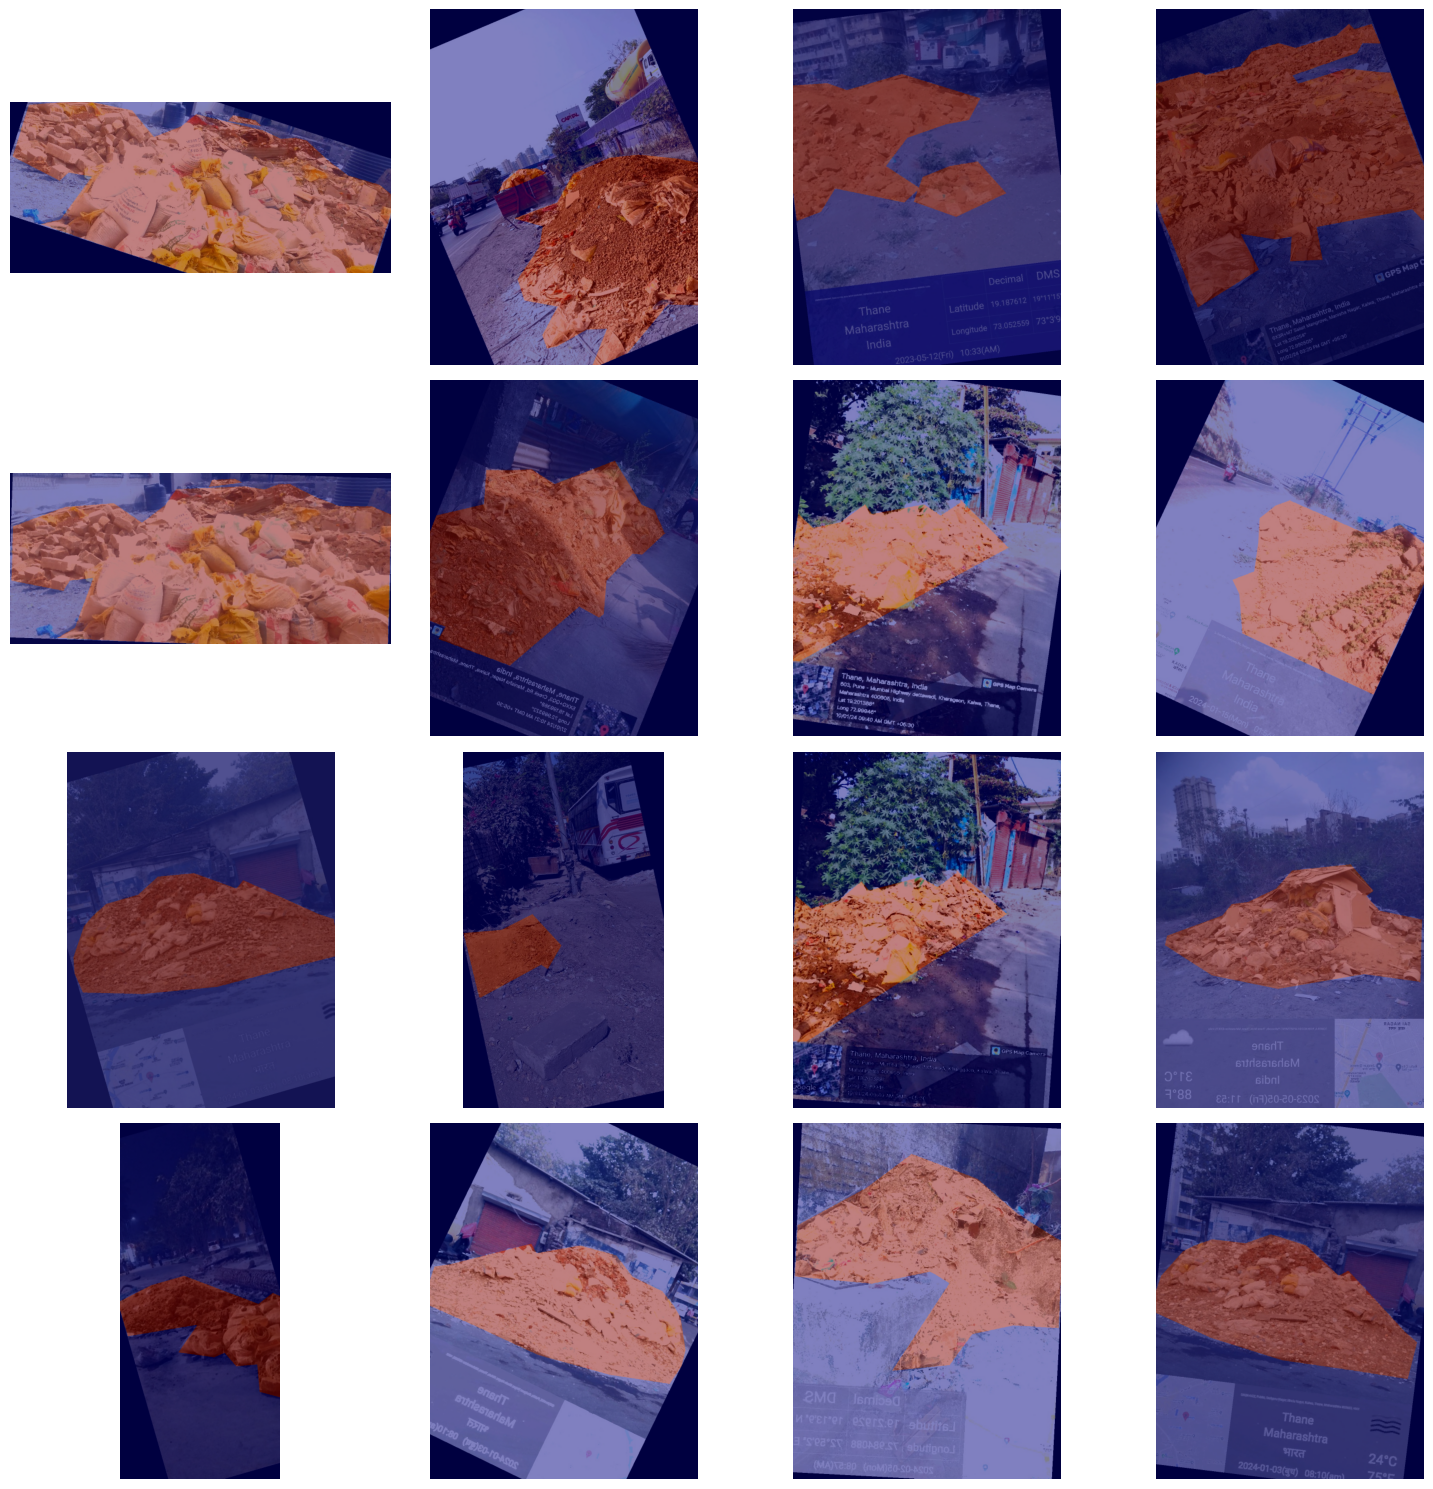

In [3]:
import os
import cv2
import random
import matplotlib.pyplot as plt

def overlay_mask_on_image(image, mask, alpha=0.5):
    """Overlay mask on the image with transparency."""
    color_mask = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
    overlayed_image = cv2.addWeighted(image, alpha, color_mask, 1 - alpha, 0)
    return overlayed_image

def display_images_in_grid(images, grid_size):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            image = images[i]
            ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            ax.axis('off')  # Hide the axis
        else:
            ax.axis('off')  # Hide empty subplots

    plt.tight_layout()
    plt.show()

# Directories for images and masks
image_dir = 'augmented_train'
output_dir = 'augmented_masks'
mask_dir = output_dir  # Directory where masks were saved

# Accumulate overlayed images
overlayed_images = []

for filename in os.listdir(image_dir):
    img_path = os.path.join(image_dir, filename)
    mask_path = os.path.join(mask_dir, filename.replace('.jpg', '.png'))

    if os.path.exists(mask_path):
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        overlayed_image = overlay_mask_on_image(image, mask)
        resized_image = cv2.resize(overlayed_image, (overlayed_image.shape[1] // 2, overlayed_image.shape[0] // 2))
        overlayed_images.append(resized_image)

        # Optionally save the overlayed image
        overlayed_image_path = os.path.join('path_to_save_overlayed_images', filename.replace('.jpg', '_overlayed.png'))
        os.makedirs('path_to_save_overlayed_images', exist_ok=True)
        cv2.imwrite(overlayed_image_path, overlayed_image)

    else:
        print("Error: Paths don't match")

# Randomly select 16 images
random.shuffle(overlayed_images)
selected_images = overlayed_images[:16]

# Display the images in a 4x4 grid
display_images_in_grid(selected_images, grid_size=(4, 4))


# Load Deeplab v3



In [8]:
import torch
from torchvision import models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from tqdm import tqdm

In [11]:
import os
from PIL import Image
from torch.utils.data import Dataset

class CustomSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Binary mask

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [12]:
from torchvision import transforms

image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

mask_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


In [13]:
from torch.utils.data import DataLoader

image_dir = '/content/augmented_train'
mask_dir = '/content/augmented_masks'
dataset = CustomSegmentationDataset(image_dir, mask_dir, transform=image_transforms)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

num_classes = 2  # Background and trash

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1))  # Adjust for binary classification
model = model.to(device)


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device).long()

        # Forward pass
        outputs = model(images)['out']
        loss = criterion(outputs, masks.squeeze(1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

print('Training complete')


DEEplab test v2


In [7]:
masks = os.listdir(mask_dir)
masks

['IMG-20240618-WA0021_aug_8.png',
 'IMG-20240618-WA0026_aug_12.png',
 'IMG-20240618-WA0025_aug_4.png',
 'IMG-20240618-WA0019_aug_16.png',
 'IMG-20240618-WA0004_aug_1.png',
 'IMG-20240618-WA0010_aug_0.png',
 'IMG-20240618-WA0015_aug_8.png',
 'IMG-20240618-WA0016_aug_10.png',
 'IMG-20240618-WA0005_aug_16.png',
 'IMG-20240618-WA0017_aug_11.png',
 'IMG-20240618-WA0007_aug_14.png',
 'IMG-20240618-WA0007_aug_6.png',
 'IMG-20240618-WA0005_aug_4.png',
 'IMG-20240618-WA0026_aug_9.png',
 'IMG-20240618-WA0020_aug_2.png',
 'IMG-20240618-WA0013_aug_1.png',
 'IMG-20240618-WA0026_aug_6.png',
 'IMG-20240618-WA0006_aug_1.png',
 'IMG-20240618-WA0006_aug_16.png',
 'IMG-20240618-WA0015_aug_15.png',
 'IMG-20240618-WA0005_aug_17.png',
 'IMG-20240618-WA0004_aug_12.png',
 'IMG-20240618-WA0004_aug_9.png',
 'IMG-20240618-WA0005_aug_2.png',
 'IMG-20240618-WA0015_aug_10.png',
 'IMG-20240618-WA0007_aug_1.png',
 'IMG-20240618-WA0025_aug_1.png',
 'IMG-20240618-WA0025_aug_7.png',
 'IMG-20240618-WA0019_aug_0.png',
 'I

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.datasets import VOCSegmentation  # Example dataset
import os
from PIL import Image

# Custom dataset example
class CustomSegmentationDataset:
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir  # Directory containing RGB images
        self.mask_dir = mask_dir    # Directory containing grayscale masks
        self.transform = transform  # Optional transformations to be applied

        # List all image and mask filenames in their respective directories
        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)

    def __len__(self):
        return len(self.images)  # Return the total number of images (or masks), assuming images and masks are paired

    def __getitem__(self, idx):
        # Construct paths to the idx-th image and mask
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        # Open and load the image (RGB)
        image = Image.open(img_path).convert("RGB")

        # Open and load the mask (grayscale)
        mask = Image.open(mask_path).convert("L")

        # Apply any transformations if specified
        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)

        # Return the image and mask as a tuple
        return image, mask

# Transformations for images and masks
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

mask_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Paths to the images and masks directories
image_dir ='/content/augmented_train'
mask_dir = '/content/augmented_masks'

# Creating the dataset and dataloader
dataset = CustomSegmentationDataset(image_dir, mask_dir, transform=image_transforms)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

# Load pre-trained DeepLabV3 model with ResNet-50 backbone
num_classes = 2  # For binary segmentation: background and trash
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1))  # Adjust for the number of classes
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device).long()

        # Forward pass
        outputs = model(images)['out']
        loss = criterion(outputs, masks.squeeze(1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# Save the trained model
model_save_path = 'save_model.pth'  # Replace with your desired save path
torch.save(model.state_dict(), model_save_path)
print('Model saved to', model_save_path)
print('Training complete')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LAB

Epoch 1/10, Loss: 0.4906
Epoch 2/10, Loss: 0.4486
Epoch 3/10, Loss: 0.4384
Epoch 4/10, Loss: 0.4288
Epoch 5/10, Loss: 0.4167
Epoch 6/10, Loss: 0.3984
Epoch 7/10, Loss: 0.3745
Epoch 8/10, Loss: 0.3461
Epoch 9/10, Loss: 0.3204
Epoch 10/10, Loss: 0.2836
Model saved to save_model.pth
Training complete


load model later:

In [9]:
from google.colab import files

# Specify the path to your model file
model_save_path = '/content/save_model.pth'

# Download the file to your local machine
files.download(model_save_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = models.segmentation.deeplabv3_resnet50(pretrained=False, num_classes=num_classes)
model.load_state_dict(torch.load(model_save_path))
model = model.to(device)
model.eval()


In [16]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the trained model (make sure you save it during/after training)
model_path = '/content/save_model.pth'  # Replace with the path to your saved model
num_classes = 2  # Background and trash

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.segmentation.deeplabv3_resnet50(pretrained=False, num_classes=num_classes)

pretrained_dict = torch.load(model_path)
model_dict = model.state_dict()

# Filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

# Load the filtered state dict
model.load_state_dict(pretrained_dict)

model = model.to(device)
model.eval()

# Preprocess the new image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image.to(device)

# Perform inference
def get_segmentation_mask(model, image):
    with torch.no_grad():
        output = model(image)['out']
    return output

# Post-process the output to get the binary mask
def postprocess_output(output):
    # Get the predicted class for each pixel
    pred = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
    return pred



# Overlay the mask on the original image
def overlay_mask(image, mask):
    # Convert mask to rgba format
    mask_rgba = np.zeros((*mask.shape, 4), dtype=np.uint8)
    mask_rgba[mask == 1] = [255, 0, 0, 100]  # Set color and transparency for class 1 (trash)
    mask_rgba[mask == 0] = [0, 0, 0, 0]      # Set transparency for class 0 (background)

    # Convert PIL image to numpy array
    image_np = np.array(image)

    # Overlay mask on image
    overlay = Image.fromarray(image_np).convert("RGBA")
    overlay = Image.alpha_composite(overlay, Image.fromarray(mask_rgba))

    return overlay

# Display the results with overlayed mask
def plot_results(image_path, mask):
    image = Image.open(image_path).convert("RGB")
    overlayed_image = overlay_mask(image, mask)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Segmentation Mask Overlay")
    plt.imshow(overlayed_image)
    plt.axis('off')

    plt.tight_layout()
    plt.show()



In [17]:
# Path to the new image
new_image_path = '/content/1.jpeg'  # Replace with the path to your new image

# Preprocess the image
image = preprocess_image(new_image_path)

# Get the segmentation mask
output = get_segmentation_mask(model, image)

# Post-process to get the final binary mask
binary_mask = postprocess_output(output)


# Display the results
plot_results(new_image_path, binary_mask)

ValueError: images do not match

In [23]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model (make sure you save it during/after training)
model_path = '/content/save_model.pth'  # Replace with the path to your saved model
num_classes = 2  # Background and trash

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.segmentation.deeplabv3_resnet50(pretrained=False, num_classes=num_classes)

pretrained_dict = torch.load(model_path)
model_dict = model.state_dict()

# Filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

# Load the filtered state dict
model.load_state_dict(pretrained_dict)


model = model.to(device)
model.eval()

# Preprocess the new image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Perform inference
def get_segmentation_mask(model, image):
    with torch.no_grad():
        output = model(image)['out']
    return output

# Post-process the output to get the binary mask
def postprocess_output(output):
    # Get the predicted class for each pixel
    pred = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
    return pred

# Path to the new image


# Plot the original image and the segmentation mask
def plot_results(image_path, mask):
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Segmentation Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.show()


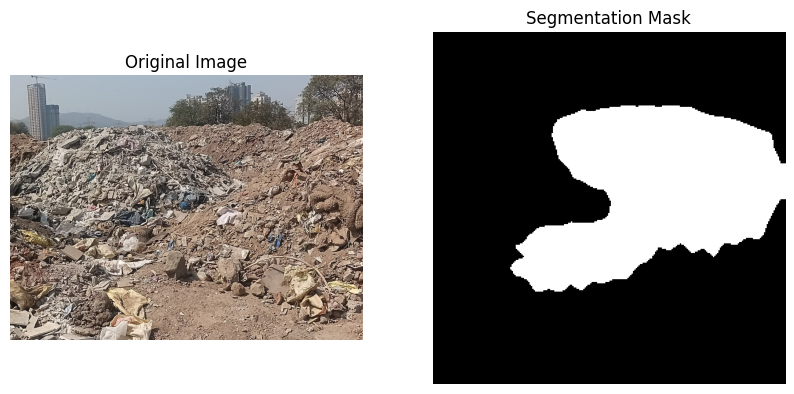

In [26]:
new_image_path = '/content/3.jpeg'  # Replace with the path to your new image

# Preprocess the image
image = preprocess_image(new_image_path).to(device)

# Get the segmentation mask
output = get_segmentation_mask(model, image)

# Post-process to get the final binary mask
binary_mask = postprocess_output(output)

# Display the results
plot_results(new_image_path, binary_mask)
